# Category Prediction on BBC-news data

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#from helper import plot_history, calc_prediction, process_text
from helper import *


from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score 
from sklearn.metrics import average_precision_score, recall_score

data_dir = './'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gshyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import json

with open(data_dir+"label_dict.json", 'r') as fp:
    label_dict = json.load(fp)

with open(data_dir+"label_dict_reversed.json", 'r') as fp:
    label_dict_reversed = json.load(fp)

print (label_dict, label_dict_reversed)

df = pd.read_csv(data_dir+'bbc_text_processed.csv')
print ('data.shape:',df.shape)
df.head(2)

{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4} {'0': 'tech', '1': 'business', '2': 'sport', '3': 'entertainment', '4': 'politics'}
data.shape: (2225, 5)


,category,text,label,text_processed,text_len
0,tech,tv future in the hands of viewers with home th...,0,tv futur hand viewer home theatr system plasma...,407
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left book alon former worldcom b...,186


## Bag of Words Method

In [3]:
from collections import Counter
ALL_WORDS = [word for text in df['text_processed'] for word in text.split() ]
words_counts = Counter(ALL_WORDS)


In [4]:
DICT_SIZE = 1000
VOCAB = words_counts.most_common(DICT_SIZE)
WORDS_TO_INDEX = {item[0]:ii for ii, item in enumerate(VOCAB) }
INDEX_TO_WORDS = {ii:word for word, ii in WORDS_TO_INDEX.items()}

In [5]:
from collections import Counter
from scipy import sparse as sp_sparse

ALL_WORDS = [word for text in df['text_processed'] for word in text.split() ]
words_counts = Counter(ALL_WORDS)

def bag_of_words(text, words_to_index):
    result_vec = np.zeros(len(words_to_index.keys()))
    for word in text.split():
        if word in words_to_index:
            result_vec[words_to_index[word]] +=1
    return result_vec

def prepare_BOW(df, col):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state = 8848)
    X_train_bow = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(text,
                                                                       WORDS_TO_INDEX)) for text in df_train[col]])
    X_test_bow = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(text,
                                                                      WORDS_TO_INDEX)) for text in df_test[col]])

    y_train = df_train['label'].values
    y_test  = df_test['label'].values
    
    print('X_train shape ', X_train_bow.shape)
    print('X_test shape ',  X_test_bow.shape)
    print('y_train shape ', y_train.shape)
    print('y_test shape ',  y_test.shape)
    
    return X_train_bow, X_test_bow, y_train, y_test

X_train_bow, X_test_bow, y_train_bow, y_test_bow = prepare_BOW(df, "text_processed")

X_train shape  (1780, 1000)
X_test shape  (445, 1000)
y_train shape  (1780,)
y_test shape  (445,)


## Model : Logistic Regression for BOW method

In [6]:
model_bow = LogisticRegression(verbose=1, solver='liblinear',
                           random_state=8848, max_iter=500)
model_bow.fit(X_train_bow, y_train_bow)

[LibLinear]

LogisticRegression(max_iter=500, random_state=8848, solver='liblinear',
                   verbose=1)

## Prediction

Method: LR (BOW)
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        81
           1       0.97      0.99      0.98        89
           2       0.98      1.00      0.99        94
           3       0.98      0.99      0.98        94
           4       1.00      0.97      0.98        87

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445




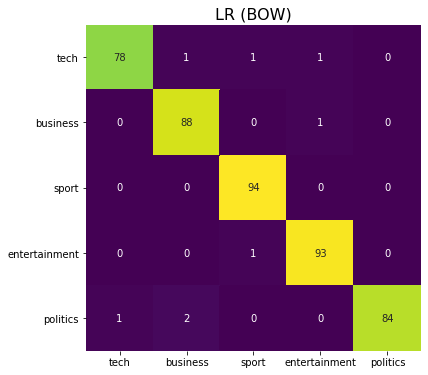

In [7]:
calc_prediction(model_bow, X_test_bow, y_test_bow, title="LR (BOW)")

## Tf-IDF method
- train, test, val split
- tokenize the text
- Use TFIDF features from sklearn

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def prepare_TFIDF(df, col):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state = 8848)

    """Extract features for given field and using different methods"""
    vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)
    vectorizer.fit_transform(df_train[col].values)
    
    X_train = vectorizer.transform(df_train[col].values)
    X_test  = vectorizer.transform(df_test[col].values)
    
    y_train = df_train['label'].values
    y_test  = df_test['label'].values

    return X_train, X_test, y_train, y_test, vectorizer

X_train_tf, X_test_tf, y_train_tf, y_test_tf, vectorizer_tf= prepare_TFIDF(df, "text_processed")

## Model : Logistic Regression for TFIDF method

In [9]:
model_tf = LogisticRegression(verbose=1, solver='liblinear',
                           random_state=8848, max_iter=500)
model_tf.fit(X_train_tf, y_train_tf)

[LibLinear]

LogisticRegression(max_iter=500, random_state=8848, solver='liblinear',
                   verbose=1)

## Prediction

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        81
           1       0.95      0.99      0.97        89
           2       0.97      1.00      0.98        94
           3       0.99      0.99      0.99        94
           4       1.00      0.95      0.98        87

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445




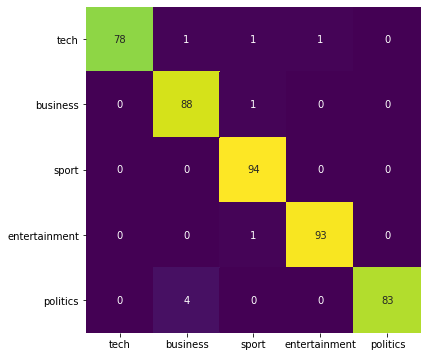

In [10]:
calc_prediction(model_tf, X_test_tf, y_test_tf)

## Predictions for new texts

In [11]:
def Prediction_tf(doc, model=model_tf, vectorizer=vectorizer_tf):    
    doc_processed = process_text(doc)
    X_in = vectorizer.transform([doc_processed])
    y_out = model.predict(X_in)[0]
    category = label_dict_reversed[str(y_out)]
    
    print (f"TFIDF Prediction \t {category}")

In [12]:
def Prediction_bow(doc, model=model_bow, WORDS_TO_INDEX=WORDS_TO_INDEX):
    doc_processed = process_text(doc)
    X_in = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(doc_processed,
                                                                WORDS_TO_INDEX)) ])
    y_out = model_bow.predict(X_in)[0]
    category = label_dict_reversed[str(y_out)]
    
    #print (f"The following text\n\n {doc} \n\n\
    print (f"Bag of Words Prediction \t {category}")

In [13]:
test_docs = get_test_doc()

for doc in test_docs:
    print ("The given doc :\n",doc[:150],"...\n")
    Prediction_bow(doc)
    Prediction_tf(doc)
    print ()
    print ()

The given doc :
 Mr Trump responded on Tuesday with his lengthiest statement since he left office a month ago. The Republican Party can never again be respected or str ...

Bag of Words Prediction 	 politics
TFIDF Prediction 	 politics


The given doc :
 England were bowled out for 134 and 164, losing all 10 second-innings wickets to spin as India levelled the four-match series at 1-1. A dry pitch was  ...

Bag of Words Prediction 	 sport
TFIDF Prediction 	 sport


The given doc :
  R. Ashwin took 5 wickets in what became the last innings of the series to secure an innings and a 25 runs. ...

Bag of Words Prediction 	 sport
TFIDF Prediction 	 entertainment


The given doc :
 True Thompson makes an adorable cameo in Khloe Kardashian's new makeup tutorial video. Many people didn't like it. ...

Bag of Words Prediction 	 sport
TFIDF Prediction 	 tech




## Neural Net : TFIDF method

In [14]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding

In [15]:
# prepare validation data
def prepare_val_set(X_train, y_train):    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.25,
                                                      random_state = 8848)
    return X_train, X_val, y_train, y_val

X_train_bow, X_test_bow_d, y_train_bow, y_test_bow_d = prepare_BOW(df, "text_processed")
X_train_tf, X_test_tf_d, y_train_tf, y_test_tf_d, vectorizer_tf= prepare_TFIDF(df, "text_processed")

X_train_bow_d, X_val_bow_d, y_train_bow_d, y_val_bow_d = prepare_val_set(X_train_bow, y_train_bow)
X_train_tf_d, X_val_tf_d, y_train_tf_d, y_val_tf_d = prepare_val_set(X_train_tf, y_train_tf)

X_train shape  (1780, 1000)
X_test shape  (445, 1000)
y_train shape  (1780,)
y_test shape  (445,)


In [16]:
# Convert ylabels to Categorical data
y_train_bow_d = to_categorical(y_train_bow_d)
y_test_bow_d = to_categorical(y_test_bow_d)
y_val_bow_d = to_categorical(y_val_bow_d)

y_train_tf_d = to_categorical(y_train_tf_d)
y_test_tf_d = to_categorical(y_test_tf_d)
y_val_tf_d = to_categorical(y_val_tf_d)


In [17]:
def make_model_dense(X_train, y_train):
    model = Sequential()
    model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [18]:
model_dense_bow = make_model_dense(X_train_bow_d, y_train_bow_d)
model_dense_bow.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


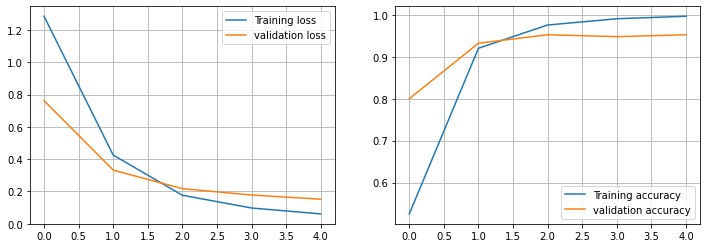

In [19]:
history_dense_bow = model_dense_bow.fit(X_train_bow_d, y_train_bow_d,
                                    validation_data=(X_val_bow_d, y_val_bow_d), 
                                    epochs=5, batch_size=32, verbose=0)

plot_history(history_dense_bow)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97        81
           1       0.94      0.98      0.96        89
           2       0.95      1.00      0.97        94
           3       0.99      0.98      0.98        94
           4       0.99      0.91      0.95        87

    accuracy                           0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445




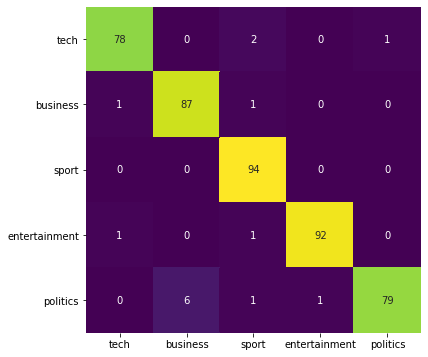

In [20]:
calc_prediction(model_dense_bow, X_test_bow_d, y_test_bow_d, categorical=True)

Method: LR (BOW)
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        81
           1       0.97      0.99      0.98        89
           2       0.98      1.00      0.99        94
           3       0.98      0.99      0.98        94
           4       1.00      0.97      0.98        87

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445


Method: LR (TFIDF)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        81
           1       0.95      0.99      0.97        89
           2       0.97      1.00      0.98        94
           3       0.99      0.99      0.99        94
           4       1.00      0.95      0.98        87

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98   

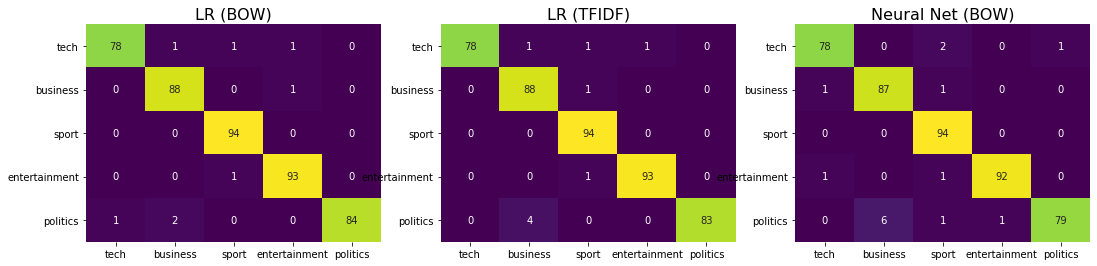

In [21]:
fig, ax=plt.subplots(1, 3, figsize=(18,4))

calc_prediction(model_bow, X_test_bow, y_test_bow, ax=ax[0], title="LR (BOW)")
calc_prediction(model_tf, X_test_tf, y_test_tf, ax=ax[1], title="LR (TFIDF)")
calc_prediction(model_dense_bow, X_test_bow_d, y_test_bow_d,
                categorical=True, ax=ax[2], title="Neural Net (BOW)")


In [22]:
#model_dense_tf = make_model_dense(X_train_tf, y_train_tf)
#model_dense_tf.summary()

#history_dense_tf = model_dense_tf.fit(X_train_tf, y_train_tf,
#                                    validation_data=(X_val_tf, y_val_tf), 
#                                    epochs=5, batch_size=32, verbose=0)

#plot_history(history_dense_tf)